In [3]:
import sys
import time

import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool

from astropy.units import Quantity
from matplotlib import dates
from sunpy.time import TimeRange

/home/ofionnad/realta/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
sys.path.insert(0,"/home/ofionnad/scripts")
from raw_class import LofarRaw

In [ ]:
##So here is a background subtraction from Pearse, but I do not use it. Including it here in case it is required in the future

In [5]:
def bg(data, amount=0.05):
        #tmp = data - np.mean(data, axis=0) 
        sdevs = np.mean(data, 1)
        cand = sorted(range(data.shape[0]), key=lambda y: sdevs[y])
        realcand = cand[:max(1, int(amount*len(cand)))]
        bg = np.mean(data[realcand, :], 0)
        return bg

In [6]:
### Reading Code

In [12]:

start = time.time() #just some brief profiling

############ Observation settings, change these for each observation
#fname = sys.argv[1]
fname = 'udpoutput/jupiter-2beams-stokesV_0_2020-10-13T17:47:00_19563125244140'
trange = TimeRange("2020/10/13 17:47:00", 10*u.min)
frange = [15,60]*u.MHz
sbs = np.arange(76, 319) # for 2/4 beams
#sbs = np.arange(76, 197)  # for 1/4 beam
obs_mode = 3
time_decimation = 16
dt = 5.12e-6 * time_decimation
resample_bool = True
resampled_dt = 1e-3
###########################################################

########## Plotting settings #############################
title = "Jupiter - Stokes V"
xtitle = "Time"
ytitle = "Frequency (MHz)"
savestring = "rawplot_source_15_60MHz.png"
###########################################################

#define raw object with data etc.
raw = LofarRaw(fname, sbs, obs_mode, trange, frange, dt=dt)
read_time = time.time() - start #profiling
print("\nTime to read raw data: {:.6f} sec\n".format(read_time))


### Resampling the time domain data, for when there is not enough memory
if resample_bool:
    resample_start = time.time()
    sum_int = int(np.floor(resampled_dt/raw.dt.sec))
    sum_shape = int(np.round(raw.data.shape[1]/sum_int))

    def resample(i):
        return np.sum(raw.data[:,i*sum_int:(i+1)*sum_int], axis=1)

    with Pool() as pool:
        resample_data = pool.map(resample, range(sum_shape))

    resample_data = np.array(resample_data)
    resample_data = np.ma.masked_equal(resample_data, 0.05)
    resample_time = time.time() - resample_start

    print("Time to resample the data : {:.6f} sec".format(resample_time))


bg_data = resample_data
#bg_data = rs_data / bg(rs_data, 0.05)

print("\nData processing done\n")


Time to read raw data: 0.006126 sec

Time to resample the data : 24.656141 sec

Data processing done



In [13]:
### Plotting 

Creating figure... ... ...

...
Image created!
...


Saving Figure!

Time to run: 108.949701 sec


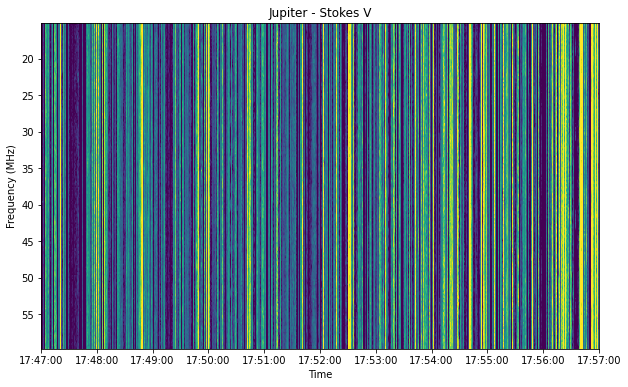

In [14]:
print("Creating figure... ... ...\n")

fig, ax = plt.subplots(figsize=(10,6))
if raw.trange is None:
    ax.imshow(bg_data.data.T, aspect='auto', 
        extent=[raw.obs_start.plot_date, raw.obs_end.plot_date,
        raw.freqs[-1].value, raw.freqs[0].value],
        vmin=np.percentile(bg_data.data, 5), vmax=np.percentile(bg_data.data,95))
else:
    ax.imshow(bg_data.data.T, aspect='auto',
        extent=[raw.trange.start.plot_date, raw.trange.end.plot_date,
        raw.freqs[-1].value, raw.freqs[0].value],
        vmin=np.percentile(bg_data.data, 5), vmax=np.percentile(bg_data.data, 95))

print("...\nImage created!\n...\n")
date_format = dates.DateFormatter("%H:%M:%S")
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)
ax.set_title(title)
ax.set_xlabel(xtitle)
ax.set_ylabel(ytitle)
print("\nSaving Figure!\n")
plt.savefig(savestring)
#plt.savefig(str(raw.obs_start)+"_raw_"+str(int(frange[0]))+"_"+str(int(frange[1]))+"MHz.png")
end = time.time() - start
print("Time to run: {:.6f} sec\n=======================".format(end))
plt.show()

In [15]:
###vispy could speed up the plotting stuff here (but would take time to work out)